# 営業データ分析ポートフォリオ
この Notebook では、以下の流れで営業データの前処理、可視化、機械学習モデルの構築・評価、そしてモデル解釈を行います。
1. データの読み込み・前処理
2. データの可視化
3. モデルの構築と評価
4. SHAP を用いたモデル解釈

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import shap
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams['font.family'] = 'Hiragino Sans'

In [2]:
def load_data(filepath):
    """
    CSV ファイルからデータを読み込みます。
    ファイルが存在しない場合は、合成データを生成します。
    """
    try:
        df = pd.read_csv(filepath)
        print(f"データを {filepath} から読み込みました。")
    except FileNotFoundError:
        print("指定ファイルが見つかりません。合成データを生成します。")
        np.random.seed(42)
        # 例として1000サンプルの合成データを生成
        df = pd.DataFrame({
            'salesperson_id': np.random.randint(1, 10, 1000),
            'client_size': np.random.choice(['small', 'medium', 'large'], 1000),
            'contact_frequency': np.random.randint(1, 20, 1000),
            'product_interest': np.random.choice(['A', 'B', 'C'], 1000),
            'last_contact_days': np.random.randint(1, 30, 1000),
            'proposal_amount': np.random.uniform(1000, 50000, 1000),
            'won': np.random.choice([0, 1], 1000, p=[0.7, 0.3])
        })
    return df

def preprocess_data(df):
    """
    データの前処理を実施します。
    - 数値・カテゴリカル変数の欠損値補完
    - アウトライヤー検出・補正（proposal_amount に対して IQR 法）
    - 特徴量エンジニアリング（例：contact_recency の作成、カテゴリ変数のダミー化）
    """
    # 数値・カテゴリカル変数の抽出
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # 数値データの欠損値補完（中央値で補完）
    imputer_num = SimpleImputer(strategy='median')
    df[numeric_cols] = imputer_num.fit_transform(df[numeric_cols])

    # カテゴリカルデータの欠損値補完（最頻値で補完）
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

    # アウトライヤー処理：proposal_amount の IQR 法によるキャッピング
    Q1 = df['proposal_amount'].quantile(0.25)
    Q3 = df['proposal_amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df['proposal_amount'] = df['proposal_amount'].clip(lower_bound, upper_bound)

    # 特徴量エンジニアリング例：連絡日の逆数（直近の連絡が大きい値になる）
    df['contact_recency'] = 1 / (df['last_contact_days'] + 1)

    # カテゴリ変数のワンホットエンコーディング
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df

# %% [code]
def visualize_data(df):
    """
    データの可視化を行い、受注・失注の傾向や営業担当者のパフォーマンスを把握します。
    """
    # 提案額の分布
    plt.figure(figsize=(10,6))
    sns.histplot(df['proposal_amount'], kde=True)
    plt.title("提案額の分布")
    plt.xlabel("提案額")
    plt.ylabel("頻度")
    plt.show()

    # 相関ヒートマップ
    plt.figure(figsize=(12,10))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("特徴量間の相関ヒートマップ")
    plt.show()

    # 営業担当者ごとの成約率
    if 'salesperson_id' in df.columns:
        performance = df.groupby('salesperson_id')['won'].mean().reset_index()
        plt.figure(figsize=(8,5))
        sns.barplot(x='salesperson_id', y='won', data=performance)
        plt.title("営業担当者ごとの成約率")
        plt.xlabel("営業担当者ID")
        plt.ylabel("成約率")
        plt.show()

# %% [code]
def build_models(X_train, y_train):
    """
    ロジスティック回帰、決定木、XGBoost の各モデルを構築し、
    GridSearchCV によるハイパーパラメータ最適化を実施します。
    戻り値は、各モデルと（必要な場合の）スケーラーの辞書です。
    """
    models = {}

    # ロジスティック回帰（スケーリング必須）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    log_reg = LogisticRegression(max_iter=1000)
    param_grid_lr = {'C': [0.1, 1, 10]}
    grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='roc_auc')
    grid_lr.fit(X_train_scaled, y_train)
    models['Logistic Regression'] = (grid_lr.best_estimator_, scaler)

    # 決定木
    dt = DecisionTreeClassifier(random_state=42)
    param_grid_dt = {'max_depth': [3, 5, 7, None]}
    grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='roc_auc')
    grid_dt.fit(X_train, y_train)
    models['Decision Tree'] = (grid_dt.best_estimator_, None)

    # XGBoost
    xgb = XGBClassifier(eval_metric='logloss', random_state=42)
    param_grid_xgb = {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]}
    grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='roc_auc')
    grid_xgb.fit(X_train, y_train)
    models['XGBoost'] = (grid_xgb.best_estimator_, None)

    return models

def evaluate_models(models, X_test, y_test):
    """
    各モデルを AUC, F1-score などの指標で評価し、結果を表示・返却します。
    """
    results = {}
    for model_name, (model, scaler) in models.items():
        X_eval = scaler.transform(X_test) if scaler is not None else X_test
        y_pred = model.predict(X_eval)
        y_proba = model.predict_proba(X_eval)[:, 1]

        auc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        results[model_name] = {'AUC': auc, 'F1-score': f1}
        print(f"--- {model_name} ---")
        print(classification_report(y_test, y_pred, zero_division=0))
        print("混同行列:")
        print(confusion_matrix(y_test, y_pred))
        print("\n")
    return results

def model_interpretation(model, X_train):
    """
    SHAP を用いて、モデルの特徴量重要度を可視化し、解釈性を向上させます。
    """
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    # 特徴量の重要度を棒グラフで可視化
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    # 全体の影響度を可視化
    shap.summary_plot(shap_values, X_train)

In [3]:
def main():
    # データの読み込み
    df = load_data("data/sales_data.csv")

    # データ前処理
    df_processed = preprocess_data(df)

    # 可視化
    visualize_data(df_processed)

    # モデリング用にターゲット変数 (won) と説明変数に分割
    target = 'won'
    if target not in df_processed.columns:
        raise ValueError("ターゲット列 'won' がデータに存在しません。")
    X = df_processed.drop(columns=[target])
    y = df_processed[target]

    # 学習用とテスト用に分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # モデル構築
    models = build_models(X_train, y_train)

    # モデル評価
    results = evaluate_models(models, X_test, y_test)
    print("各モデルの評価結果:")
    for model_name, metrics in results.items():
        print(f"{model_name}: AUC = {metrics['AUC']:.3f}, F1-score = {metrics['F1-score']:.3f}")

    # 最も性能の良いモデル（AUC が最大）を選択し SHAP で解釈
    best_model_name = max(results, key=lambda k: results[k]['AUC'])
    best_model, scaler = models[best_model_name]
    X_train_eval = scaler.transform(X_train) if scaler is not None else X_train
    print(f"\n最も性能の良いモデル: {best_model_name} の解釈を実施します。")
    model_interpretation(best_model, X_train_eval)

指定ファイルが見つかりません。合成データを生成します。


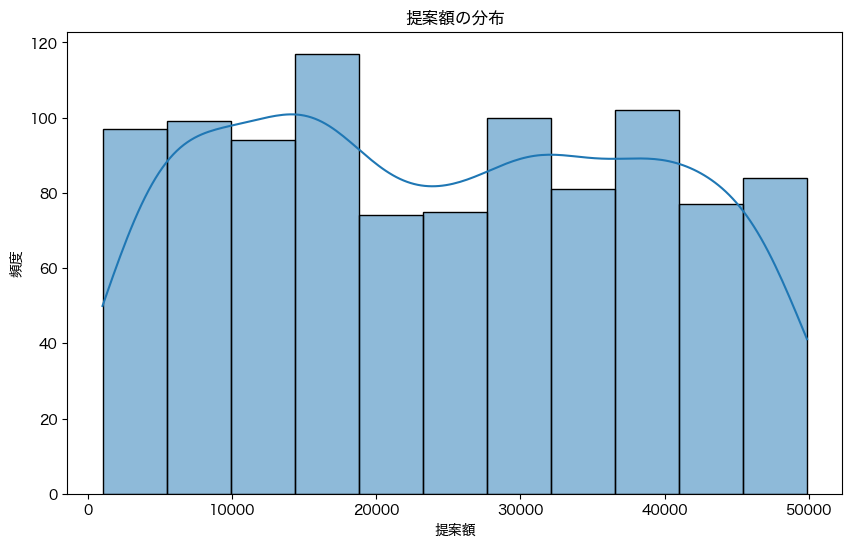

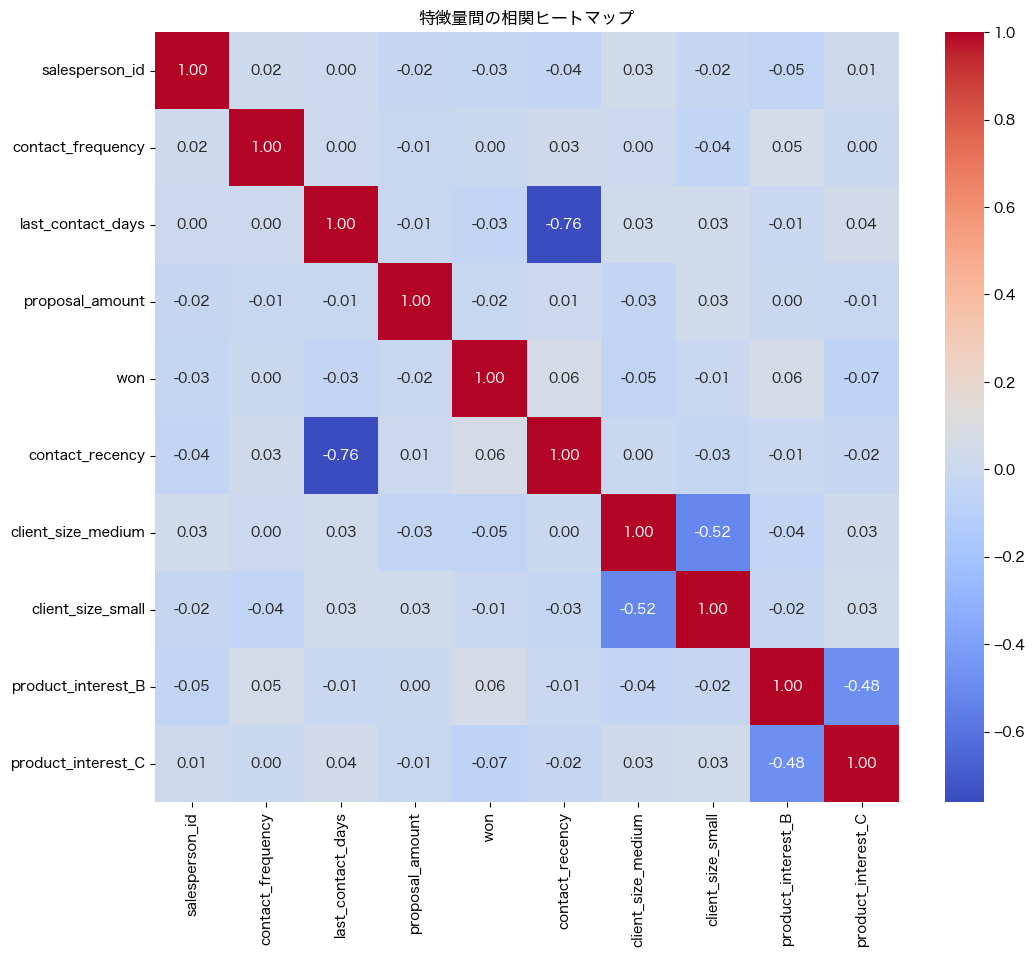

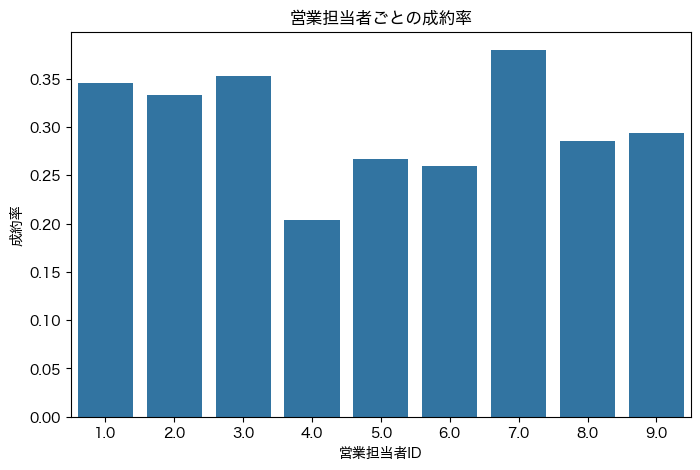

--- Logistic Regression ---
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82       140
         1.0       0.00      0.00      0.00        60

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.49      0.70      0.58       200

混同行列:
[[140   0]
 [ 60   0]]


--- Decision Tree ---
              precision    recall  f1-score   support

         0.0       0.72      0.94      0.81       140
         1.0       0.50      0.13      0.21        60

    accuracy                           0.70       200
   macro avg       0.61      0.54      0.51       200
weighted avg       0.65      0.70      0.63       200

混同行列:
[[132   8]
 [ 52   8]]


--- XGBoost ---
              precision    recall  f1-score   support

         0.0       0.71      0.93      0.80       140
         1.0       0.41      0.12      0.18        60

    accuracy                           0.69       200


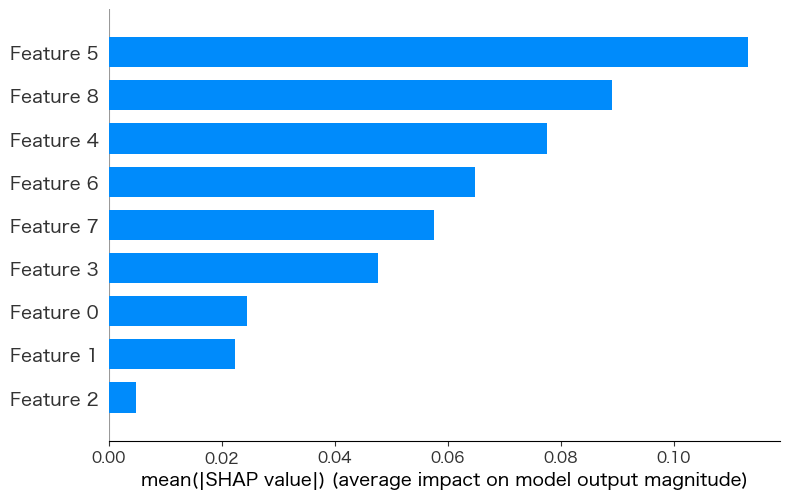

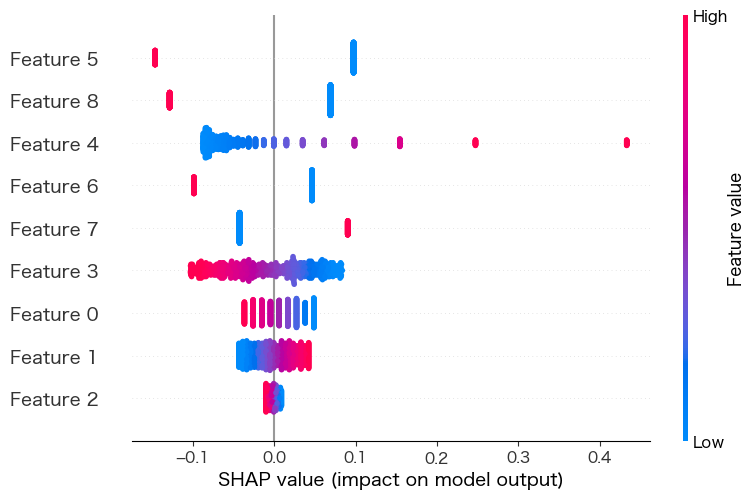

In [4]:
main()